In [218]:
import numpy as np
import matplotlib.pyplot as plt

(2, 500)

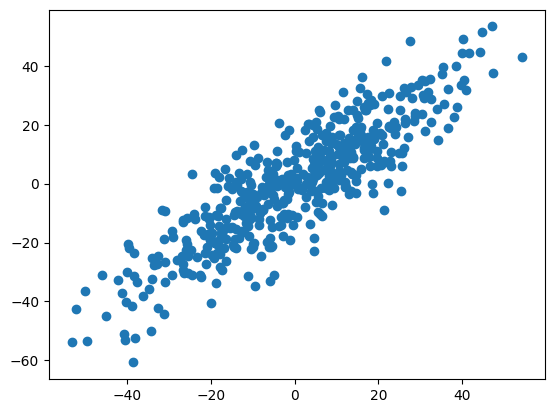

In [219]:
np.random.seed(0)

mean = [100, 150]  # center of data
cov = [[400, 350],
       [350, 400]]  # spread of data

X = np.random.multivariate_normal(mean, cov, size=500).T
X = X - X.mean(axis=1, keepdims=True)

X.shape
_ = plt.scatter(*X)

# PCA `C = XX'/n`

In [220]:
n = X.shape[1]
C = X @ X.T / n
C.shape

(2, 2)

In [230]:
eigenvalues, eigenvectors = np.linalg.eigh(C)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

eigenvalues
eigenvectors

array([710.85000857,  49.98748657])

array([[ 0.70498801, -0.70921922],
       [ 0.70921922,  0.70498801]])

In [231]:
np.cumsum(eigenvalues) / sum(eigenvalues)

array([0.93429939, 1.        ])

In [232]:
k = 2
W = eigenvectors[:, :k]
W

array([[ 0.70498801, -0.70921922],
       [ 0.70921922,  0.70498801]])

In [233]:
coefficients = X.T @ W
coefficients.shape

(500, 2)

In [234]:
X_ = (coefficients @ W.T).T
X_.shape

(2, 500)

In [235]:
np.sqrt(np.mean((X - X_)**2))  # rmse

np.float64(1.7497370811199439e-15)

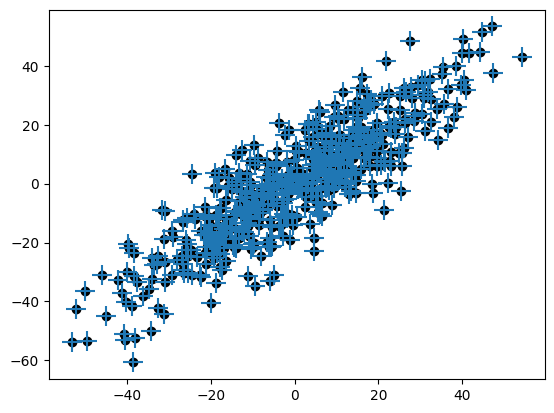

In [236]:
_ = plt.scatter(*X, color='k')
_ = plt.scatter(*X_, marker="+", s=200)

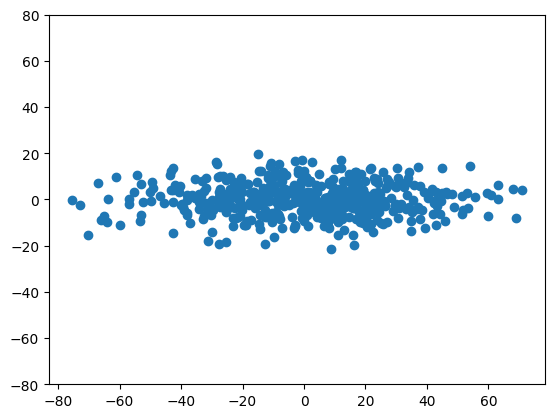

In [238]:
_ = plt.scatter(*coefficients.T)
_ = plt.ylim((-80, 80))